## LD block definition for the nanopore haplotype inference project
### Yosuke Tanigawa (2017/7/26)

## Summary:
This note describes
1. PLINK --blocks command to generate .block.det file
1. method to generate bed file (region, not the genotype file) for our definition of LD blocks

We imposed extra filter on the SNPs in the input data:
- hwe 1e-10
- genotype rate >= 10%

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import bisect

In [2]:
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

## 1) PLINK --blocks command
- We used plink 1.9 --blocks option to compute the LD blocks
- https://www.cog-genomics.org/plink2/ld

In [3]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'

In [4]:
!cat $data_dir'/'$geno_bed_log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/private_data/ukbb/pgen/chr20impv1
  --biallelic-only strict
  --geno
  --hwe 1e-10 midp
  --keep /share/PI/mrivas/data/ukbb/phefiles/initialdata/1389.phe
  --maf 0.005
  --make-bed
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --snps-only just-acgt

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:24:21 2017

Random number seed: 1498260261
257674 MB RAM detected; reserving 30000 MB for main workspace.
1540220 out of 1619597 variants loaded from .bim file.
152249 people (0 males, 0 females, 152249 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.nosex
.
--keep: 112338 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Befo

In [5]:
!cat $data_dir'/'$block_log

PLINK v1.90b3.45 64-bit (13 Jan 2017)
Options in effect:
  --bfile /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10
  --blocks no-pheno-req no-small-max-span
  --blocks-inform-frac 0.10
  --blocks-max-kb 1000
  --blocks-recomb-highci 0.830001
  --blocks-strong-highci 0.830001
  --blocks-strong-lowci 0.50001
  --memory 30000
  --out /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10

Hostname: sh-102-07.int
Working directory: /home/users/ytanigaw
Start time: Fri Jun 23 16:32:58 2017

Random number seed: 1498260778
257674 MB RAM detected; reserving 30000 MB for main workspace.
198418 variants loaded from .bim file.
112338 people (0 males, 0 females, 112338 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-bl

### blocks.det file
- the results of the PLINK 1.9 --blocks command is shown below:

In [6]:
block_det_f = '{}/{}.blocks.det'.format(
    data_dir,
    block_log[:-4]
)

In [7]:
block_det = pd.read_csv(block_det_f, sep='\s+')
print(block_det.shape)
block_det.loc[[x for x in range(3)] + [len(block_det) - x for x in range(3, 0, -1)]]

(642, 6)


,CHR,BP1,BP2,KB,NSNPS,SNPS
0,20,62731,93931,31.201,30,rs34147676|rs6139074|rs1418258|rs13043000|rs60...
1,20,94952,266511,171.560,545,rs1857092|rs80192833|rs6052070|rs6515824|rs605...
2,20,266792,287529,20.738,56,rs6137140|rs6082182|rs6082191|rs6082211|rs6075...
639,20,62475881,62481217,5.337,16,rs2427539|rs6010682|rs2427540|rs6010683|rs8120...
640,20,62481351,62871658,390.308,760,rs73149487|rs6062547|rs2768476|rs12624502|rs12...
641,20,62871952,62918861,46.910,110,rs2983433|rs2427625|rs41309379|rs11699386|rs41...


### The mean and median of size and # SNPs
- Here, SNPs with 5% + is used to define our blocks

In [8]:
print(np.mean(block_det.KB), np.median(block_det.KB))
print(np.mean(block_det.NSNPS), np.median(block_det.NSNPS))

91.540046728972 25.4125
194.96728971962617 50.0


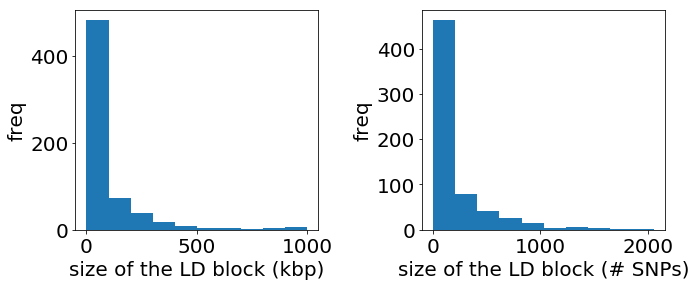

In [9]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)
axs = [fig.add_subplot(ss) for ss in gs]
axs[0].hist(block_det.KB)
axs[1].hist(block_det.NSNPS)
axs[0].set_xlabel('size of the LD block (kbp)')
axs[1].set_xlabel('size of the LD block (# SNPs)')
axs[0].set_ylabel('freq')
axs[1].set_ylabel('freq')
# axs[0].set_title('')
# axs[1].set_title('')
# fig_conf_curves.suptitle('')
gs.tight_layout(fig, rect=[0, 0, 1, 0.88])

## 2) conver to bed file
### motivation
- The blocks we found in the previous step does not fully cover the chromosome

### method
- Given the block.det file and bim file (that has all the SNPs we consider), we *define* LD-based blocks
- block.det is essentially a list of intervals [[BP1_1, BP2_1), [BP1_2, BP2_2), ... , [BP1_n, BP2_n)]
  - [x, y) denotes semi-open intervals where x is included in the interval while y isn't
- Our definition of the blocks are: [[0, BP1_2), [BP1_2, BP1_3), [BP1_3, BP1_4), ... , [BP1_{n-1}, BP1_n), [BP1_{n-1}, end_of_chromosome]]

In [10]:
bim_f = '{}/{}'.format(
    data_dir,
    'chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.bim'
)

bim = pd.read_csv(bim_f, sep='\t', names=['chr', 'rsid', 'genetic_dist', 'pos', 'a1', 'a2'])
print(bim.shape)
bim.loc[[x for x in range(3)] + [len(bim) - x for x in range(3, 0, -1)]]

(198418, 6)


,chr,rsid,genetic_dist,pos,a1,a2
0,20,rs6078030,0,61098,T,C
1,20,rs143291093,0,61270,C,A
2,20,rs4814683,0,61795,T,G
198415,20,rs73628077,0,62956564,A,G
198416,20,rs11698187,0,62960292,G,A
198417,20,rs542224338,0,62963102,C,T


- bim file is 1-indexed (for genomic positions, 4-th filed)
- check several statistics

In [11]:
block_det.BP1[0], block_det.BP2.as_matrix()[-1], bim.pos[0], bim.pos.as_matrix()[-1], len(block_det), len(bim)

(62731, 62918861, 61098, 62963102, 642, 198418)

- convert to intervals that cover the entire chromosome

In [12]:
interval_points = np.zeros(len(block_det) + 1, dtype=np.int)
interval_points[1:-1] = [x - 1 for x in block_det.BP1.as_matrix()[1:]]
interval_points[0] = bim.pos[0] - 1
interval_points[-1] = bim.pos[len(bim) -1] - 1

- we also want to store the intervals on bim-id space

In [13]:
bim_pos_0index = bim.pos.map(lambda x: x - 1).as_matrix()
bim_pos_0index

array([   61097,    61269,    61794, ..., 62956563, 62960291, 62963101])

In [14]:
interval_points_bimid = np.array([bisect.bisect_right(bim_pos_0index, x) - 1 for x in interval_points])
interval_points_bimid[:10]

array([   0,   78,  915,  991, 1218, 1224, 1355, 1405, 1838, 1887])

In [15]:
interval_points[:10]

array([ 61097,  94951, 266791, 288775, 344630, 346675, 368904, 381669,
       536535, 546545])

In [16]:
bim.loc[interval_points_bimid[:10]]

,chr,rsid,genetic_dist,pos,a1,a2
0,20,rs6078030,0,61098,T,C
78,20,rs1857092,0,94952,T,G
915,20,rs6137140,0,266792,A,G
991,20,rs4815163,0,288776,T,C
1218,20,rs6084202,0,344631,A,G
1224,20,rs56266078,0,346676,T,C
1355,20,rs2295490,0,368905,G,A
1405,20,rs113654934,0,381670,T,C
1838,20,rs204670,0,536536,T,G
1887,20,rs204700,0,546546,A,G


### the results are represented as a data frame and stored in a bed file

In [17]:
bed_df = pd.DataFrame({
    'chrom': ['chr20'] * len(block_det),
    'chromStart': interval_points[:-1],
    'chromEnd':   interval_points[1:],
    'bimIdStart': interval_points_bimid[:-1],
    'bimIdEnd':   interval_points_bimid[1:]
})

In [18]:
bed_df['name'] = ['{}:{}'.format(bed_df.bimIdStart[x], bed_df.bimIdEnd[x]) for x in range(len(bed_df))]

In [19]:
print(bed_df.shape)
bed_df.loc[
    [x for x in range(3)] + [len(bed_df) - x for x in range(3, 0, -1)],
    ['chrom', 'chromStart', 'chromEnd', 'bimIdStart', 'bimIdEnd', 'name']]

(642, 6)


,chrom,chromStart,chromEnd,bimIdStart,bimIdEnd,name
0,chr20,61097,94951,0,78,0:78
1,chr20,94951,266791,78,915,78:915
2,chr20,266791,288775,915,991,915:991
639,chr20,62475880,62481350,196982,197010,196982:197010
640,chr20,62481350,62871951,197010,198256,197010:198256
641,chr20,62871951,62963101,198256,198417,198256:198417


In [20]:
bed_f = '{}.bed'.format(block_det_f[:-11])
print(bed_f)

/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.bed


In [21]:
bed_df[['chrom', 'chromStart', 'chromEnd', 'name']].to_csv(bed_f, header=False, index=False, sep='\t')

In [22]:
!head $bed_f

chr20	61097	94951	0:78
chr20	94951	266791	78:915
chr20	266791	288775	915:991
chr20	288775	344630	991:1218
chr20	344630	346675	1218:1224
chr20	346675	368904	1224:1355
chr20	368904	381669	1355:1405
chr20	381669	536535	1405:1838
chr20	536535	546545	1838:1887
chr20	546545	549906	1887:1901


### the size of the blocks

In [23]:
bed_df['len'] = bed_df.chromEnd - bed_df.chromStart
bed_df['nSNPs'] = bed_df.bimIdEnd - bed_df.bimIdStart

In [24]:
print(np.mean(block_det.KB), np.median(block_det.KB))
print(np.mean(bed_df.len/1000), np.median(bed_df.len/1000))

91.540046728972 25.4125
97.97819937694705 27.0065


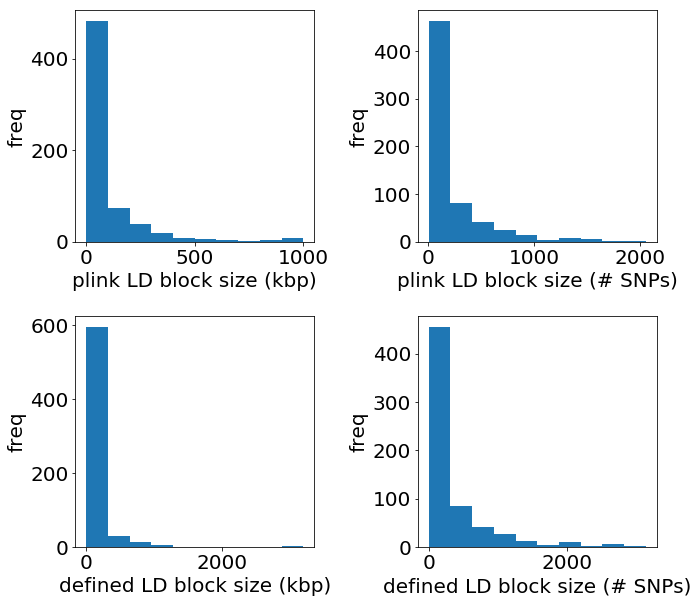

In [25]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
axs = [fig.add_subplot(ss) for ss in gs]
axs[0].hist(block_det.KB)
axs[1].hist(block_det.NSNPS)
axs[2].hist(bed_df.len/1000)
axs[3].hist(bed_df.nSNPs)
axs[0].set_xlabel('plink LD block size (kbp)')
axs[1].set_xlabel('plink LD block size (# SNPs)')
axs[2].set_xlabel('defined LD block size (kbp)')
axs[3].set_xlabel('defined LD block size (# SNPs)')
for ax in axs:
    ax.set_ylabel('freq')
gs.tight_layout(fig, rect=[0, 0, 1, 0.88])

### The smallest blocks ( top 5 )

In [26]:
bed_df.sort_values(by='len').head()

,bimIdEnd,bimIdStart,chrom,chromEnd,chromStart,name,len,nSNPs
56,10391,10388,chr20,2751854,2751793,10388:10391,61,3
500,166000,165996,chr20,54542871,54542621,165996:166000,250,4
457,155363,155359,chr20,51691988,51691670,155359:155363,318,4
589,184164,184160,chr20,59562419,59562076,184160:184164,343,4
483,159542,159539,chr20,52822641,52822248,159539:159542,393,3


### The largest blocks (top 5)

In [27]:
bed_df.sort_values(by='len', ascending=False).head()

,bimIdEnd,bimIdStart,chrom,chromEnd,chromStart,name,len,nSNPs
294,92240,92200,chr20,29479933,26285873,92200:92240,3194060,40
310,104273,102848,chr20,35449879,34445163,102848:104273,1004716,1425
293,92200,90220,chr20,26285873,25285219,90220:92200,1000654,1980
296,94529,92343,chr20,30526402,29526084,92343:94529,1000318,2186
306,100545,98914,chr20,33538520,32538390,98914:100545,1000130,1631
